In [194]:
import numpy as np
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


# чтение данных
df = pd.read_csv('data/data.csv')

In [195]:
# переименование столбцов
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  object 
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [197]:
# приводим поле treatment к бинарному виду
df.treatment.value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [198]:
df.loc[df.treatment == 'No Offer', 'treatment'] = 0
df.loc[(df.treatment == 'Discount'), 'treatment'] = 1
df.loc[df.treatment == 'Buy One Get One', 'treatment'] = 1

In [199]:
#df = df.astype({'treatment': int})
df.treatment.value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [200]:
df.groupby('treatment')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


In [201]:
# разбиение набора данных на тренировочную и тестовую выборки

indices_learn, indices_valid = train_test_split(df.index, test_size=0.3, random_state=17)

In [202]:
X_train = df.loc[indices_learn, :]
X_train = X_train.drop(columns='target')
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']

X_val = df.loc[indices_valid, :]
X_val = X_val.drop(columns='target')
y_val = df.loc[indices_valid, 'target']
treat_val = df.loc[indices_valid, 'treatment']

cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@30%': [],
    'uplift@20%': [],
    'uplift@10%': []
}

### 1. Подходы с одной моделью

#### 1.1 Одна модель с признаком коммуникации

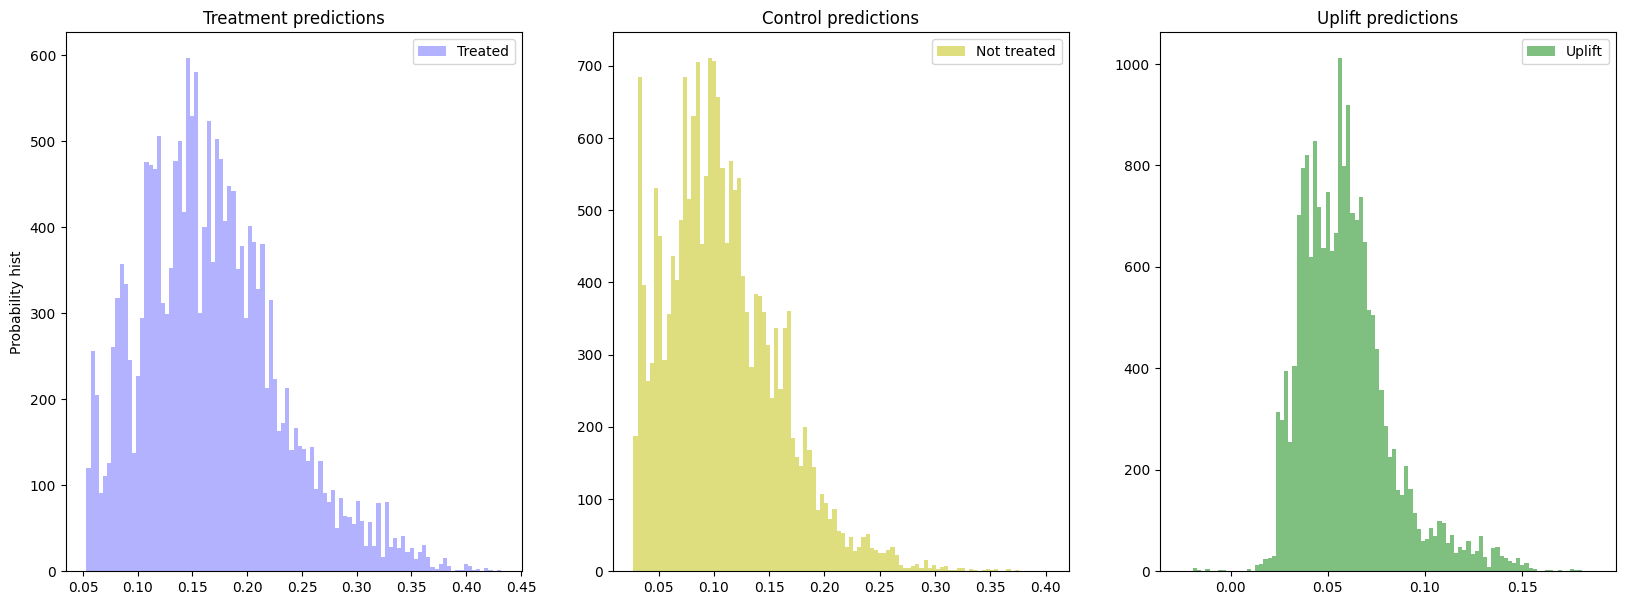

In [203]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=17, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score_30)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@10%'].append(sm_score_10)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ признаки

In [204]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,21.185614
1,treatment,18.869362
2,recency,13.589208
3,used_bogo,11.647620
4,zip_code,10.037702
5,history,9.660318
6,channel,7.839618
7,used_discount,7.170559


### 1.2 Трансформация классов

In [205]:
from sklift.models import ClassTransformation

ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=17, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score_30)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@10%'].append(ct_score_10)


### 2.1 Две независимые модели

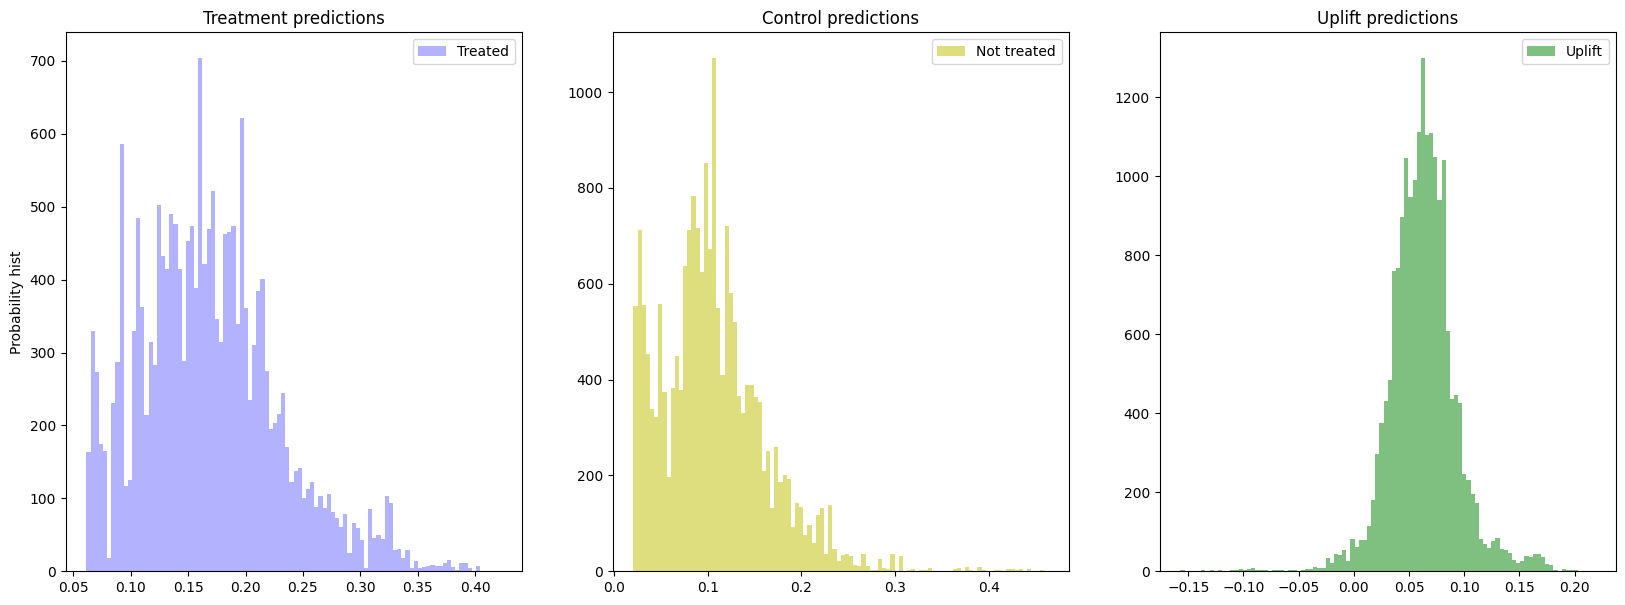

In [206]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt = CatBoostClassifier(iterations=20, thread_count=2, random_state=17, silent=True),
    estimator_ctrl = CatBoostClassifier(iterations=20, thread_count=2, random_state=17, silent=True),
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features},
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=.3)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=.2)
tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=.1)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score_30)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@10%'].append(tm_score_10)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

In [207]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@30%,uplift@20%,uplift@10%
1,ClassTransformation,0.175510,0.203640,0.241162
2,TwoModels,0.076994,0.087875,0.107067
0,SoloModel,0.081458,0.087505,0.105605


### Вариант с деревом решений

In [208]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

ModuleNotFoundError: No module named 'causalml.inference'